In [1]:
import sys
import os
import pandas as pd
import numpy as np
import time
import requests

# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

In [21]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "categories": {
        "institutions": "all",
        "mex_consar_siefore": "all"
    },
    "request": [
        {
            "table": "mex_consar_siefore_net_assets",
            "variables": [
                "9f96f4336f46d2a"
            ]
        }
    ]
}

response_net_assets = get_tukan_api_request(payload)
net_assets_df = response_net_assets["data"]
net_assets_var = response_net_assets["variables"]

Success getting the data


In [23]:
siefore_df = net_assets_df[(net_assets_df["mex_consar_siefore__ref"] == "86b76bae90f30fe")].copy()
siefore_df.loc[:,"lag_yoy"] = siefore_df.groupby("institutions__ref")["9f96f4336f46d2a"].shift(12)
siefore_df.loc[:,"lag_mom"] = siefore_df.groupby("institutions__ref")["9f96f4336f46d2a"].shift(1)

# Compute growth

siefore_df.loc[:,"yoy_growth"] = siefore_df["9f96f4336f46d2a"]/siefore_df["lag_yoy"] - 1
siefore_df.loc[:,"mom_growth"] = siefore_df["9f96f4336f46d2a"]/siefore_df["lag_mom"] - 1

siefore_df.loc[:,"mkt_share_cons"] = siefore_df["9f96f4336f46d2a"]/siefore_df[siefore_df["institutions__ref"] == "8e2a795df927a38"]["9f96f4336f46d2a"].iloc[0]
siefore_df = siefore_df[siefore_df["institutions__ref"] != "8e2a795df927a38"].copy()
cons_mkt = siefore_df.sort_values(by = "mkt_share_cons", ascending=False)
cons_mkt = cons_mkt.head(6)

In [1]:
fig = plt.figure(figsize = (10, 4), dpi = 300)
ax = plt.subplot(111)

ax.spines["left"].set_visible(False)
ax.yaxis.set_visible(False)
cmap = mpl.cm.get_cmap("Blues_r", 7)

left = 0
for index, data in enumerate(cons_mkt["mkt_share_cons"]):
    institution = cons_mkt["institutions"].iloc[index]
    cons = cons_mkt["9f96f4336f46d2a"].iloc[index]/1000000000
    if index % 2 == 0:
        mult_aux = -1
    else:
        mult_aux = 1
    ax.annotate(
        f"{institution} {round(data*100,2)} %\n(MXN {cons:,.0f} Bn.)",
        xy=(left + data/2, 0),
        xycoords="data",
        xytext=(0, mult_aux*75),
        textcoords="offset points",
        color="black",
        size=7.75,
        va="center",
        ha="center",
        weight="bold",
        arrowprops=dict(
        arrowstyle="->", ec="black", connectionstyle="arc3"
        ),
    )
    if cons_mkt["institutions"].iloc[index] == "Banamex":
        ax.barh(0, data, left=left, zorder = 3, ec = "black", color = cmap(index))      
    else:
        ax.barh(0, data, left=left, zorder = 3, ec = "black", color = cmap(index))
    left += data


ax.annotate(
    f"Others {round((1 - left)*100,2)} %",
    xy=(left + (1 - left)/2, 0),
    xycoords="data",
    xytext=(0, -1*75),
    textcoords="offset points",
    color="black",
    size=9,
    va="center",
    ha="center",
    weight="bold",
    arrowprops=dict(
    arrowstyle="->", ec="black", connectionstyle="arc3"
    ),
)
ax.barh(0, 1 - left, left=left, zorder = 3, ec = "black", color = cmap(7))

ax.set_ylim(-1.5,1.5)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1%}'))
plt.savefig(
    "plots/afore_net_assets.svg",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

NameError: name 'plt' is not defined

In [61]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "institutions"
    ],
    "categories": {
        "institutions": "all"
    },
    "request": [
        {
            "table": "mex_consar_afore_balance_sheet",
            "variables": [
                "aaabada5fb35b5e"
            ]
        }
        # {
        #     "table": "mex_consar_afore_income_statement",
        #     "variables": [
        #         "41ed2726f53af05"
        #     ]
        # }
    ],
    "from": "2012-01-12"
}

reponse = get_tukan_api_request(payload)
data = reponse["data"]

Success getting the data


In [64]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "institutions"
    ],
    "categories": {
        "institutions": "all"
    },
    "request": [
        # {
        #     "table": "mex_consar_afore_balance_sheet",
        #     "variables": [
        #         "aaabada5fb35b5e"
        #     ]
        # },
        {
            "table": "mex_consar_afore_income_statement",
            "variables": [
                "41ed2726f53af05"
            ]
        }
    ],
    "from": "2012-01-12"
}

reponse = get_tukan_api_request(payload)
data_2 = reponse["data"]

Success getting the data


In [66]:
merged_df = pd.merge(data, data_2)

In [67]:

merged_df.sort_values(by = ['institutions__ref', 'date'], inplace = True)
merged_df = merged_df.reset_index(drop = True).copy()

In [68]:
# LTM Profit (loss)
merged_df.loc[:,'ltm_profit'] = (
    merged_df.groupby(['institutions__ref'])
    .rolling(on="date", window=12, min_periods=12)['41ed2726f53af05']
    .sum()
    .reset_index(drop = True)
)

# Average equity
merged_df.loc[:,'ltm_equity'] = (
    merged_df.groupby(['institutions__ref'])
    .rolling(on='date', window=12, min_periods=12)['aaabada5fb35b5e']
    .mean()
    .reset_index(drop = True)
)


#-----------------------------------------------------------------------------
# Compute the financial ratios
#-----------------------------------------------------------------------------

merged_df.loc[:,'roe'] = merged_df.loc[:,'ltm_profit'] / merged_df.loc[:,'ltm_equity']



In [65]:
data_2 = data_2.sort_values(by='date')

data_2['lag'] = (data_2.groupby(['institutions'], as_index=False).apply(lambda x: x.shift(1)["41ed2726f53af05"]).reset_index(level=0, drop=True))

data_2['41ed2726f53af05_2'] = np.where(data_2['date'].dt.month == 1,
                            data_2['41ed2726f53af05'], data_2['41ed2726f53af05'] - data_2['lag'])
data_2['41ed2726f53af05'] = np.where(pd.isna(data_2['41ed2726f53af05']), data_2['41ed2726f53af05'], data_2['41ed2726f53af05_2'])

data_2.drop(['lag', '41ed2726f53af05_2'], axis=1, inplace=True)
data_2 = data_2[pd.notna(data_2['41ed2726f53af05'])].reset_index(drop=True)


In [81]:
merged_df[merged_df["institutions"] == "Afore Citibanamex"]

,date,institutions__ref,institutions,aaabada5fb35b5e,41ed2726f53af05,ltm_profit,ltm_equity,roe
905,2013-04-01,efdef488d1513cb,Afore Citibanamex,7.043230e+09,233134100.0,NaN,NaN,NaN
906,2013-05-01,efdef488d1513cb,Afore Citibanamex,7.133215e+09,89984400.0,NaN,NaN,NaN
907,2013-06-01,efdef488d1513cb,Afore Citibanamex,5.174699e+09,41484200.0,NaN,NaN,NaN
908,2013-07-01,efdef488d1513cb,Afore Citibanamex,5.314017e+09,139318300.0,NaN,NaN,NaN
909,2013-08-01,efdef488d1513cb,Afore Citibanamex,5.415925e+09,101907700.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1004,2021-07-01,efdef488d1513cb,Afore Citibanamex,1.163012e+10,276728200.0,3.230492e+09,1.022380e+10,0.315978
1005,2021-08-01,efdef488d1513cb,Afore Citibanamex,1.188594e+10,255335100.0,3.118807e+09,1.048330e+10,0.297502
1006,2021-09-01,efdef488d1513cb,Afore Citibanamex,1.205387e+10,167441000.0,3.061233e+09,1.073801e+10,0.285084
1007,2021-10-01,efdef488d1513cb,Afore Citibanamex,1.236148e+10,226221300.0,3.075694e+09,1.100066e+10,0.279592


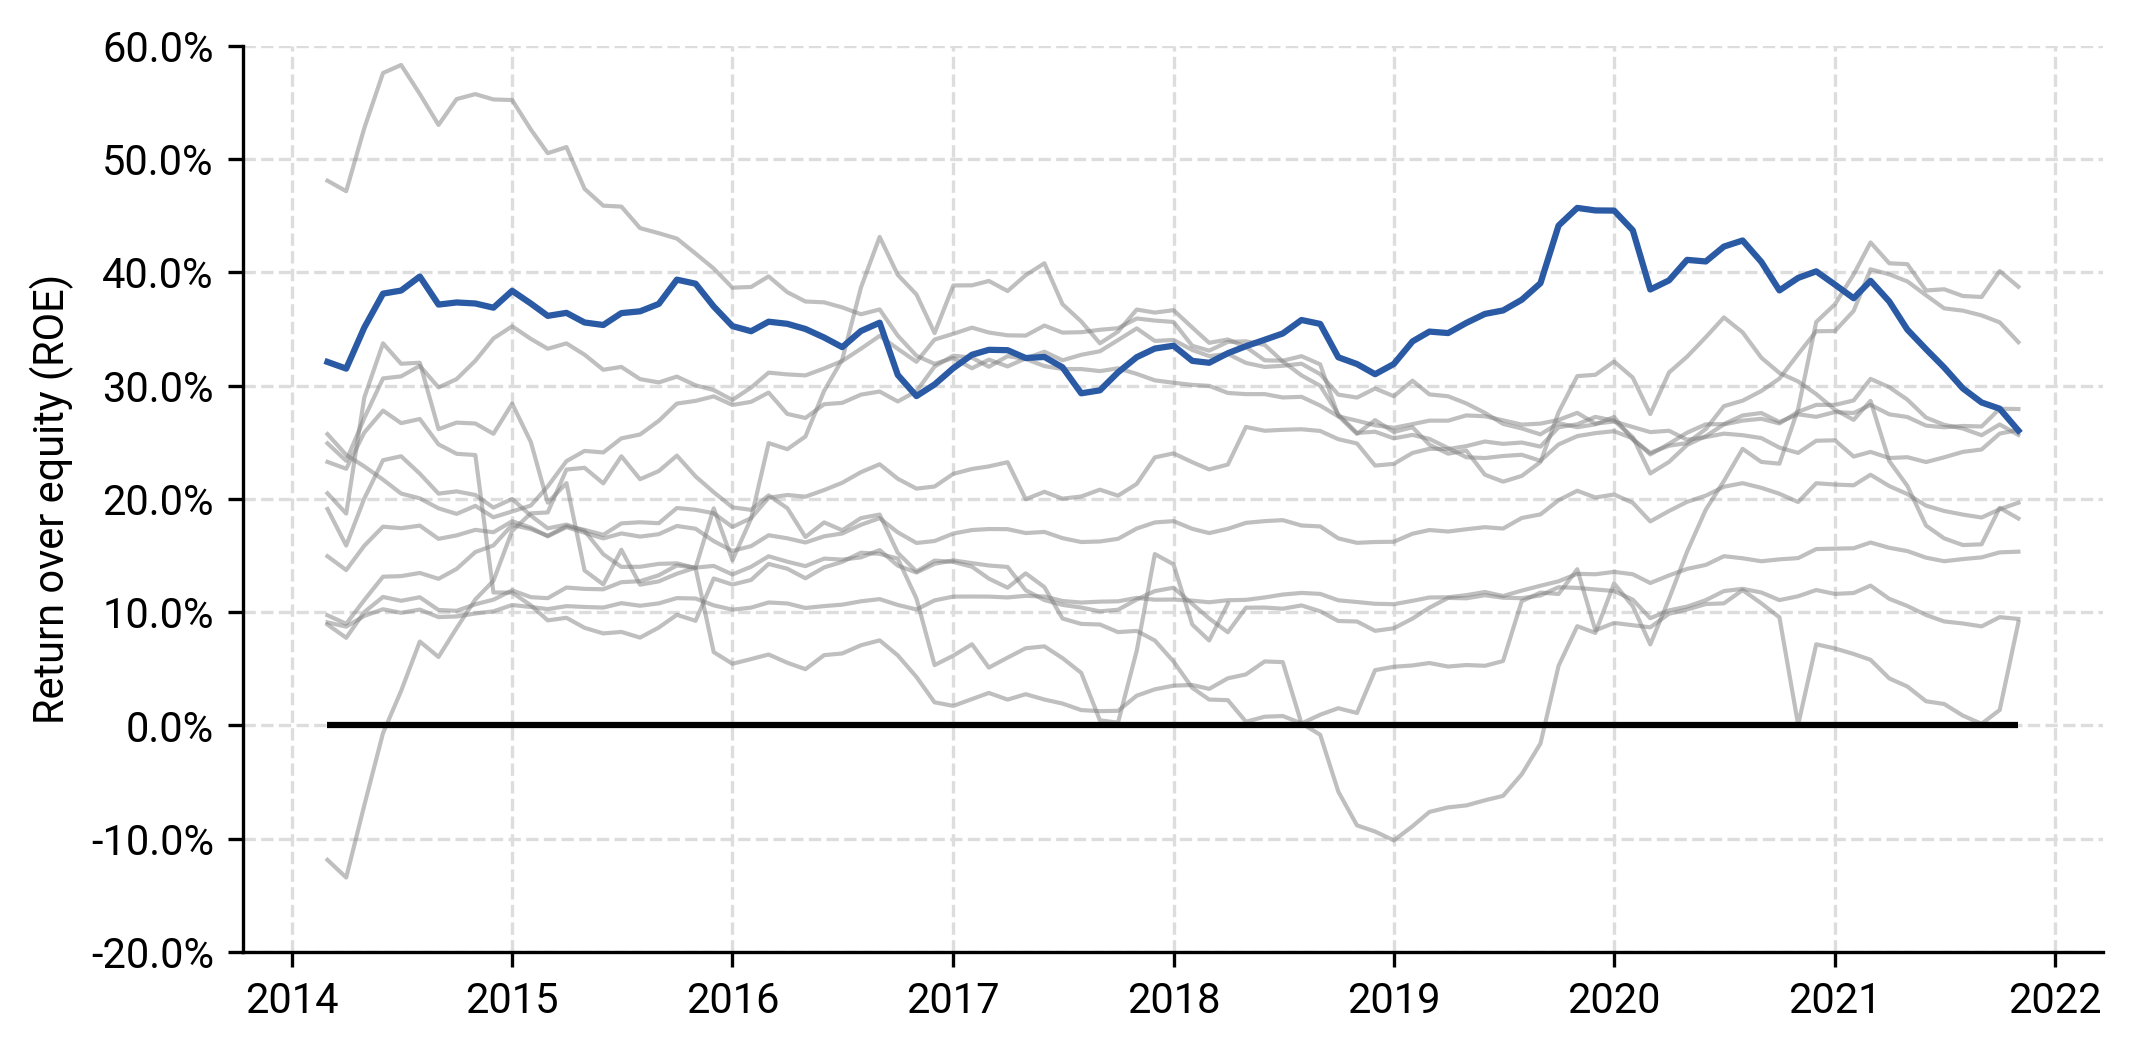

In [80]:
fig = plt.figure(figsize = (8, 4), dpi = 300)
ax = plt.subplot(111)

for x in merged_df["institutions"].unique():
    aux_df = merged_df[merged_df["institutions"] == x].copy()
    if x == "Afore Citibanamex":
        ax.plot(aux_df["date"], aux_df["roe"], label = x, zorder = 20)
    # elif x == "HSBC México":
    #     aux_df = aux_df[aux_df["date"] > "2004-01-01"]
    #     ax.plot(aux_df["date"], aux_df["roe"], color = "gray", alpha = 0.5, linewidth = 1)
    else:
        ax.plot(aux_df["date"], aux_df["roe"], color = "gray", alpha = 0.5, linewidth = 1)
    


ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1%}'))
ax.set_ylim(-.2,.6)
# ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol = 2)
ax.hlines(0, xmin = merged_df["date"].iloc[11], xmax = aux_df["date"].max(), color = "black")
ax.yaxis.set_label_text("Return over equity (ROE)")
plt.savefig(
    "plots/roe_afore_banamex.svg",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)